# 8주차 스터디: Multi Assets 퀀트 전략 구현 

지난 주에는 한개의 주식만으로 전략을 구현했습니다. 오늘은 여러 개의 주식을 가지고 구현하겠습니다

**Made by 35기 코딩부장 류제현**

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

## 1. Cross-Sectional 모멘텀 전략 구현

     Cross-Sectional Momentum을 계산하고, Momentum(수익률)이 높은 주식을 매수, 
     
     낮은 주식은 매도하는 전략을 구현해 봅시다 (Long-Short 전략)

In [2]:
# 데이터를 불러옵니다
all_stock = pd.read_csv("new_us_etf_stock.csv",
                        index_col=0, 
                        parse_dates=True) #parse_dates = True를 통해 알아서 자동으로 date time으로 인지

In [3]:
# 데이터 확인
all_stock

,Code,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
1980-12-12,AAPL,0.513393,0.515625,0.513393,0.513393,0.410525,117258400.0
1980-12-15,AAPL,0.488839,0.488839,0.486607,0.486607,0.389106,43971200.0
1980-12-16,AAPL,0.453125,0.453125,0.450893,0.450893,0.360548,26432000.0
1980-12-17,AAPL,0.462054,0.464286,0.462054,0.462054,0.369472,21610400.0
1980-12-18,AAPL,0.475446,0.477679,0.475446,0.475446,0.380182,18362400.0
...,...,...,...,...,...,...,...
2019-06-18,WMT,109.800003,109.959999,108.910004,109.650002,109.650002,4911200.0
2019-06-19,WMT,109.800003,109.839996,108.870003,109.620003,109.620003,3924600.0
2019-06-20,WMT,109.820000,110.489998,109.279999,110.320000,110.320000,5001500.0


In [4]:
all_stock['Code'].unique() #어떤 ETF가 있나 분석 가능

array(['AAPL', 'AMZN', 'BND', 'GLD', 'SLV', 'GDX', 'GM', 'MSFT', 'SPY',
       'USM', 'USO', 'WMT'], dtype=object)

In [5]:
# pivot해줍시다 (수정종가를 사용하겠습니다)
price = pd.pivot_table(data=all_stock,
                       values="Adj Close",
                       index=all_stock.index, 
                       columns="Code")

#pivot 테이블은 간단하게 말해 데이터를 요약하는 기술입니다. 즉, 내 입맛에 맞게 데이터들을 약간만 조정해보자는 취지입니다. (엑셀의 피벗테이블을 생각해보세요.)
#엑셀에서처럼 기초 데이터를 가지고 원하는 정보만 이용해 표로 만드는 기술입니다. 

In [6]:
# 데이터 확인
price = price.dropna() #각 자산마다 상장된 날들이 다르기에 공통적으로 겹치는 날부터 시작되는 것을 보이기 위해
price

Code,AAPL,AMZN,BND,GDX,GLD,GM,MSFT,SLV,SPY,USM,USO,WMT
Date,,,,,,,,,,,,
2010-11-18,38.599087,164.169998,64.823563,55.564148,132.089996,27.027195,20.902266,26.350000,100.572983,40.089294,35.500000,43.252506
2010-11-19,38.386353,164.820007,64.839478,55.799461,132.199997,27.082527,20.780931,26.740000,100.849663,40.123600,35.220001,43.581024
2010-11-22,39.216064,170.389999,65.029739,56.505428,133.479996,26.940243,20.813284,27.170000,100.765846,39.746208,35.049999,43.573009
2010-11-23,38.636639,168.199997,65.045670,56.119507,134.410004,26.284130,20.319853,26.870001,99.307045,39.231586,34.950001,43.004116
2010-11-24,39.396286,177.250000,64.736313,56.166569,134.179993,26.465942,20.522078,26.940001,100.774223,40.149334,36.080002,43.276539
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-18,198.449997,1901.369995,82.397118,23.670000,127.120003,36.700001,135.160004,14.050000,290.984741,50.540001,11.250000,109.650002
2019-06-19,197.869995,1908.790039,82.676468,24.000000,127.889999,36.779999,135.690002,14.170000,291.641541,50.040001,11.330000,109.620003
2019-06-20,199.460007,1918.189941,82.806168,25.049999,131.110001,36.959999,136.949997,14.450000,294.427979,49.320000,11.850000,110.320000


In [9]:
# 수익률 계산 후 저장
rtn = price.pct_change().dropna() #수익률을 계산하기에 첫번째 열 값은 NaN이 될 것이고 이를 드롭 해줍시다.

In [10]:
# 확인
rtn #역시나 첫번째 행인 2010-11-18은 없네요

Code,AAPL,AMZN,BND,GDX,GLD,GM,MSFT,SLV,SPY,USM,USO,WMT
Date,,,,,,,,,,,,
2010-11-19,-0.005511,0.003959,0.000246,0.004235,0.000833,0.002047,-0.005805,0.014801,0.002751,0.000856,-0.007887,0.007595
2010-11-22,0.021615,0.033794,0.002934,0.012652,0.009682,-0.005254,0.001557,0.016081,-0.000831,-0.009406,-0.004827,-0.000184
2010-11-23,-0.014775,-0.012853,0.000245,-0.006830,0.006967,-0.024354,-0.023708,-0.011042,-0.014477,-0.012948,-0.002853,-0.013056
2010-11-24,0.019661,0.053805,-0.004756,0.000839,-0.001711,0.006917,0.009952,0.002605,0.014774,0.023393,0.032332,0.006335
2010-11-26,0.000635,-0.000282,0.002328,-0.017764,-0.007974,0.009558,-0.004730,-0.030067,-0.011647,0.002136,-0.003049,-0.004999
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-18,0.023518,0.008133,0.002306,0.008951,0.005060,0.015495,0.017388,0.010791,0.010471,0.143957,0.040703,0.004489
2019-06-19,-0.002923,0.003902,0.003390,0.013942,0.006057,0.002180,0.003921,0.008541,0.002257,-0.009893,0.007111,-0.000274
2019-06-20,0.008036,0.004925,0.001569,0.043750,0.025178,0.004894,0.009286,0.019760,0.009554,-0.014389,0.045896,0.006386


In [11]:
# 상대 모멘텀(월간) 계산을 위해 데이터를 resample합니다 (last는 resample 이전의 마지막 값을 가져옵니다)
## BM은 Business Day / Month를 의미합니다
resample = price.resample("BM").last() #last 대신 first, mean, median 도 가능
resample

Code,AAPL,AMZN,BND,GDX,GLD,GM,MSFT,SLV,SPY,USM,USO,WMT
Date,,,,,,,,,,,,
2010-11-30,38.939499,175.399994,64.958382,56.006550,135.419998,27.035101,20.433100,27.440001,99.340576,39.265892,36.040001,43.340633
2010-12-31,40.367420,180.000000,64.295433,58.251236,138.720001,29.137827,22.576715,30.180000,105.981735,42.833958,39.000000,43.451035
2011-01-31,42.464890,169.639999,64.351532,51.096581,129.869995,28.845346,22.431110,27.389999,108.451126,41.804710,38.610001,45.175205
2011-02-28,44.203182,173.289993,64.540276,56.697117,137.660004,26.505461,21.627945,33.110001,112.218414,42.868267,39.189999,41.879921
2011-03-31,43.614983,180.130005,64.445282,56.952976,139.860001,24.529219,20.659649,36.770000,112.231895,44.163410,42.599998,42.230255
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-28,172.485748,1639.829956,78.877831,22.240000,123.989998,38.677559,111.616837,14.630000,276.114929,46.689999,11.950000,97.939934
2019-03-29,189.221313,1780.750000,80.407143,22.420000,122.010002,36.706638,117.505043,14.180000,281.112762,45.910000,12.500000,97.014641
2019-04-30,199.900192,1926.520020,80.387283,20.889999,121.199997,38.537029,130.118362,14.020000,292.596893,48.099998,13.290000,102.296577


In [12]:
# 한달간의 수익률을 계산합니다, 수익률을 위에서도 구하고 아래에서도 구해서 당황하실 수도 있을 것 같습니다.
# 하지만 이 코드는 모멘텀을 알아보기 위한 것입니다. 바로 자산군별 상대적 성과 비교를 위한 것이죠(누가 누가 이번달에 더 잘했나요)
monthly_rtn = resample.pct_change().dropna()
monthly_rtn

Code,AAPL,AMZN,BND,GDX,GLD,GM,MSFT,SLV,SPY,USM,USO,WMT
Date,,,,,,,,,,,,
2010-12-31,0.036670,0.026226,-0.010206,0.040079,0.024369,0.077778,0.104909,0.099854,0.066852,0.090869,0.082131,0.002547
2011-01-31,0.051959,-0.057556,0.000873,-0.122824,-0.063798,-0.010038,-0.006449,-0.092445,0.023300,-0.024029,-0.010000,0.039681
2011-02-28,0.040935,0.021516,0.002933,0.109607,0.059983,-0.081118,-0.035806,0.208835,0.034737,0.025441,0.015022,-0.072945
2011-03-31,-0.013307,0.039471,-0.001472,0.004513,0.015981,-0.074560,-0.044771,0.110541,0.000120,0.030212,0.087012,0.008365
2011-04-29,0.004648,0.087048,0.014637,0.034942,0.089447,0.034160,0.020874,0.274952,0.028961,-0.043698,0.059859,0.056292
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-28,0.044776,-0.045906,-0.000901,-0.019833,-0.006092,0.011789,0.077358,-0.027907,0.032416,-0.189128,0.052863,0.032975
2019-03-29,0.097026,0.085936,0.019388,0.008094,-0.015969,-0.050958,0.052754,-0.030759,0.018101,-0.016706,0.046025,-0.009448
2019-04-30,0.056436,0.081859,-0.000247,-0.068243,-0.006639,0.049865,0.107343,-0.011283,0.040852,0.047702,0.063200,0.054445


In [13]:
# 상대 모멘텀의 순위를 구하기 위해 rank로 변환 (영업사원들간의 실적 발표 시간)
rank = monthly_rtn.rank(axis=1)
rank

Code,AAPL,AMZN,BND,GDX,GLD,GM,MSFT,SLV,SPY,USM,USO,WMT
Date,,,,,,,,,,,,
2010-12-31,5.0,4.0,1.0,6.0,3.0,8.0,12.0,11.0,7.0,10.0,9.0,2.0
2011-01-31,12.0,4.0,9.0,1.0,3.0,6.0,8.0,2.0,10.0,5.0,7.0,11.0
2011-02-28,9.0,6.0,4.0,11.0,10.0,1.0,3.0,12.0,8.0,7.0,5.0,2.0
2011-03-31,3.0,10.0,4.0,6.0,8.0,1.0,2.0,12.0,5.0,9.0,11.0,7.0
2011-04-29,2.0,10.0,3.0,7.0,11.0,6.0,4.0,12.0,5.0,1.0,9.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-28,10.0,2.0,6.0,4.0,5.0,7.0,12.0,3.0,8.0,1.0,11.0,9.0
2019-03-29,12.0,11.0,8.0,6.0,4.0,1.0,10.0,2.0,7.0,3.0,9.0,5.0
2019-04-30,9.0,11.0,4.0,1.0,3.0,7.0,12.0,2.0,5.0,6.0,10.0,8.0


In [14]:
# Rank가 7 이상이면 매수, 7 미만이면 매도하겠습니다
signal = np.where(rank >= 7, 1, -1) 
signal

array([[-1, -1, -1, ...,  1,  1, -1],
       [ 1, -1,  1, ..., -1,  1,  1],
       [ 1, -1, -1, ...,  1, -1, -1],
       ...,
       [ 1,  1, -1, ..., -1,  1,  1],
       [-1, -1,  1, ..., -1, -1,  1],
       [ 1, -1, -1, ...,  1, -1,  1]])

In [15]:
# 판다스 곱으로 수익률을 계산하기 위해, signal을 데이터프레임으로 변경
signal_df = pd.DataFrame(signal, 
                         index=rank.index,
                         columns=rank.columns)
signal_df

Code,AAPL,AMZN,BND,GDX,GLD,GM,MSFT,SLV,SPY,USM,USO,WMT
Date,,,,,,,,,,,,
2010-12-31,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1
2011-01-31,1,-1,1,-1,-1,-1,1,-1,1,-1,1,1
2011-02-28,1,-1,-1,1,1,-1,-1,1,1,1,-1,-1
2011-03-31,-1,1,-1,-1,1,-1,-1,1,-1,1,1,1
2011-04-29,-1,1,-1,1,1,-1,-1,1,-1,-1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-28,1,-1,-1,-1,-1,1,1,-1,1,-1,1,1
2019-03-29,1,1,1,-1,-1,-1,1,-1,1,-1,1,-1
2019-04-30,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1


In [16]:
# Monthly로 기록된 signal을 Daily로 Reindex 해주겠습니다
## reindex함수는 인덱스를 다시 설정하지만, 원래 있는 값은 그대로 남겨둡니다
signal_df_daily = signal_df.reindex(price.index)
signal_df_daily

Code,AAPL,AMZN,BND,GDX,GLD,GM,MSFT,SLV,SPY,USM,USO,WMT
Date,,,,,,,,,,,,
2010-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# dropna를 해주면 바로 위에서 한 말을 알 수 있습니다 (단지 어떤 것에 데이터가 있는지 보여주기 위해 있는 라인)
signal_df_daily.dropna()

Code,AAPL,AMZN,BND,GDX,GLD,GM,MSFT,SLV,SPY,USM,USO,WMT
Date,,,,,,,,,,,,
2010-12-31,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0
2011-01-31,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0
2011-02-28,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0
2011-03-31,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0
2011-04-29,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-31,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0
2019-02-28,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0
2019-03-29,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0


In [18]:
# 다음으로, signal을 ffill해주겠습니다 (한달단위로 포지션을 변경하기 때문에)
signal_f = signal_df_daily.ffill()
signal_f

Code,AAPL,AMZN,BND,GDX,GLD,GM,MSFT,SLV,SPY,USM,USO,WMT
Date,,,,,,,,,,,,
2010-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-18,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0
2019-06-19,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0
2019-06-20,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0


In [19]:
signal_f.loc['2011-02-01', 'AAPL'] #2010-12-31. 2011-01-30, 2011-02-01

1.0

In [20]:
# 첫 한달은 한달치 수익이 아직 나오지 않았기 때문에 NaN 값이 발생합니다
## 이 값은 0으로 채워줍시다
signal_ls = signal_df_daily.ffill().fillna(0)
signal_ls

Code,AAPL,AMZN,BND,GDX,GLD,GM,MSFT,SLV,SPY,USM,USO,WMT
Date,,,,,,,,,,,,
2010-11-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-11-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-11-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-11-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-11-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-18,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0
2019-06-19,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0
2019-06-20,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0


In [21]:
# Long-Short 전략이기 때문에, signal의 합은 0이 나와야 합니다 (Long-Only일 경우에는 1이었습니다)
signal_ls.sum(1)

Date
2010-11-18    0.0
2010-11-19    0.0
2010-11-22    0.0
2010-11-23    0.0
2010-11-24    0.0
             ... 
2019-06-18    0.0
2019-06-19    0.0
2019-06-20    0.0
2019-06-21    0.0
2019-06-24    0.0
Length: 2162, dtype: float64

In [22]:
# Long-Short 전략은 weight의 합이 0입니다.
## 이 말은, Long을 10, Short을 -10을 가져가도 합이 0, Long을 0.1, Short을 -0.1로 가져가도 합이 0이 됩니다
### 이 비율을 어떻게 가져갈지는 전략을 세우는 사람의 자유입니다
#### 여기서는 Long 1, Short 1을 맞추겠습니다

signal_final = signal_ls / 6
signal_final

Code,AAPL,AMZN,BND,GDX,GLD,GM,MSFT,SLV,SPY,USM,USO,WMT
Date,,,,,,,,,,,,
2010-11-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-11-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-11-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-11-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-11-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-18,-0.166667,-0.166667,0.166667,0.166667,0.166667,-0.166667,0.166667,0.166667,-0.166667,-0.166667,-0.166667,0.166667
2019-06-19,-0.166667,-0.166667,0.166667,0.166667,0.166667,-0.166667,0.166667,0.166667,-0.166667,-0.166667,-0.166667,0.166667
2019-06-20,-0.166667,-0.166667,0.166667,0.166667,0.166667,-0.166667,0.166667,0.166667,-0.166667,-0.166667,-0.166667,0.166667


In [23]:
# 앞에서 구한 일간 수익률 데이터프레임과 시그널 데이터 프레임을 곱해줍니다
## 데이터프레임끼리 곱해주는 아이디어는 굉장히 중요한 아이디어입니다
### 1과 수익을 곱하면 그냥 수익이 그대로 나오고, -1과 수익을 곱하면 공매도 수익이 나옵니다. 

strategy_rtn = rtn * signal_final.shift(1) # signal을 하루 밀어주는 게 필요하겠죠?
strategy_rtn

Code,AAPL,AMZN,BND,GDX,GLD,GM,MSFT,SLV,SPY,USM,USO,WMT
Date,,,,,,,,,,,,
2010-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-19,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000
2010-11-22,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000
2010-11-23,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
2010-11-24,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-18,-0.003920,-0.001356,0.000384,0.001492,0.000843,-0.002583,0.002898,0.001799,-0.001745,-0.023993,-0.006784,0.000748
2019-06-19,0.000487,-0.000650,0.000565,0.002324,0.001010,-0.000363,0.000654,0.001423,-0.000376,0.001649,-0.001185,-0.000046
2019-06-20,-0.001339,-0.000821,0.000261,0.007292,0.004196,-0.000816,0.001548,0.003293,-0.001592,0.002398,-0.007649,0.001064


In [24]:
# 누적 수익률을 계산해봅시다
final_rtn = (strategy_rtn.sum(1) + 1).cumprod()
final_rtn

Date
2010-11-18    1.000000
2010-11-19    1.000000
2010-11-22    1.000000
2010-11-23    1.000000
2010-11-24    1.000000
                ...   
2019-06-18    1.186983
2019-06-19    1.193500
2019-06-20    1.202852
2019-06-21    1.209066
2019-06-24    1.223810
Length: 2162, dtype: float64

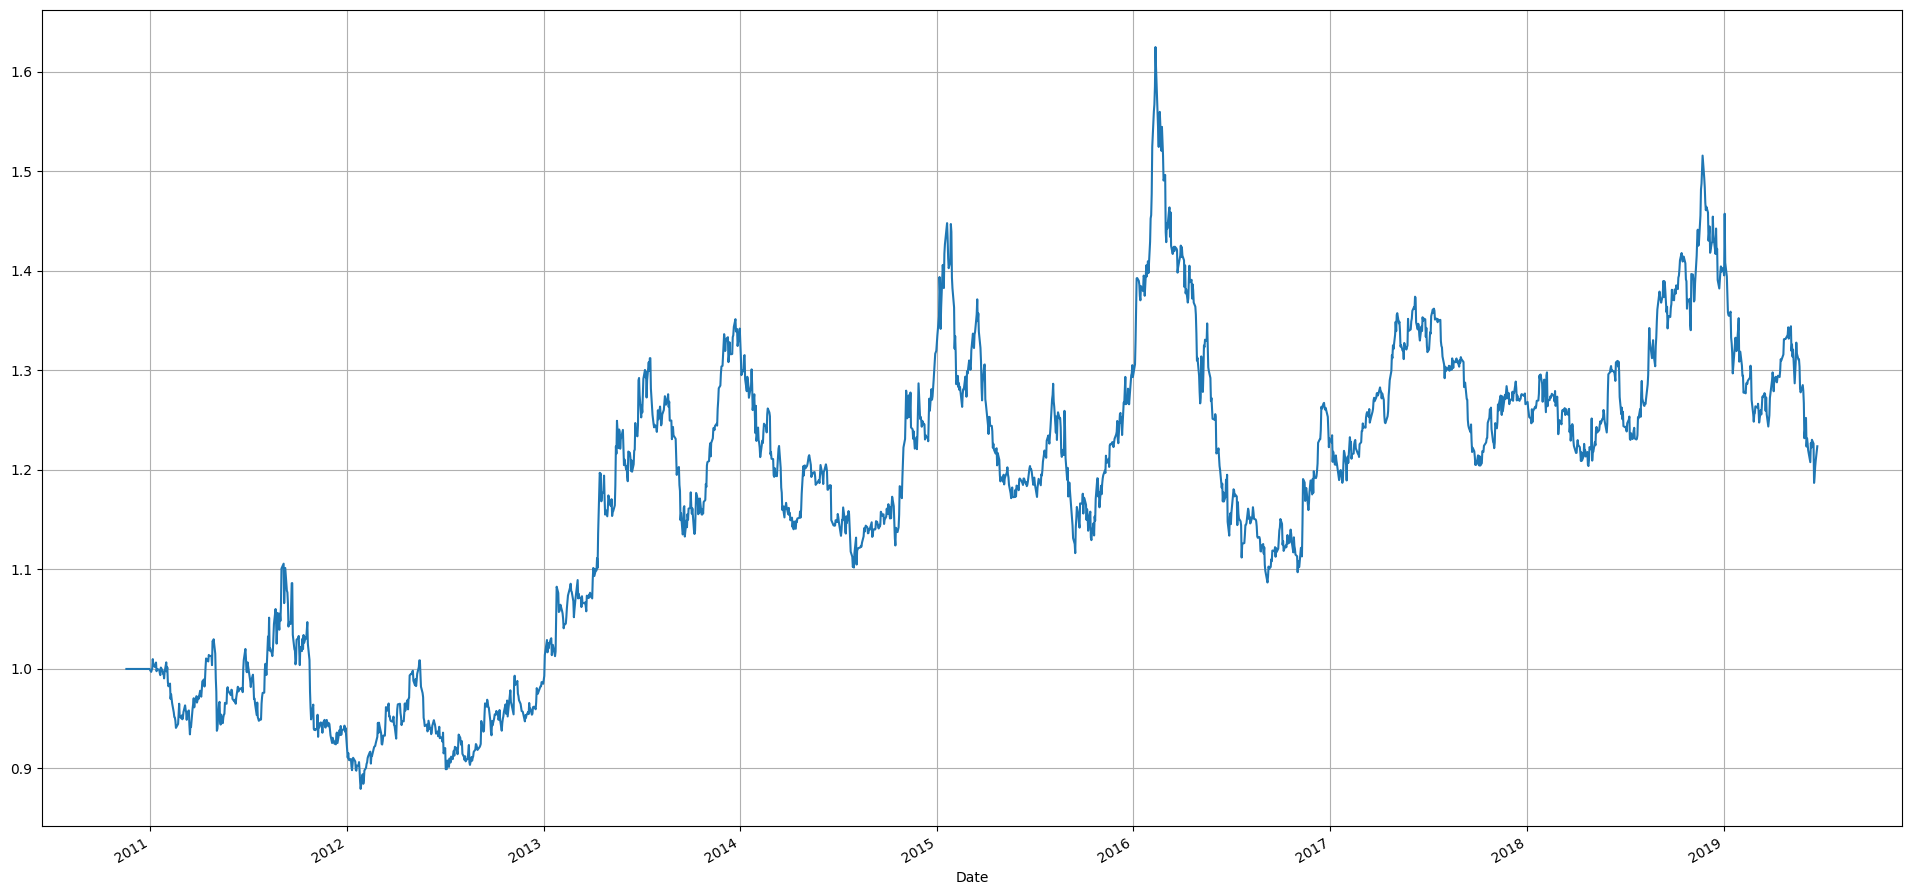

In [ ]:
# 누적 수익률을 Plot 해봅시다
final_rtn.plot(figsize=(24,12))
plt.grid();

## 2. Multi Assets 이평선 전략

Week 7에서 배웠던 내용과 동일한 구현입니다

    20일 이평선을 뚫으면 사고, 반대일 경우 파는 전략을 Multi Assets에 대해 구현해보자

In [25]:
# 앞에서 사용했던 똑같은 데이터 프레임을 사용
price

Code,AAPL,AMZN,BND,GDX,GLD,GM,MSFT,SLV,SPY,USM,USO,WMT
Date,,,,,,,,,,,,
2010-11-18,38.599087,164.169998,64.823563,55.564148,132.089996,27.027195,20.902266,26.350000,100.572983,40.089294,35.500000,43.252506
2010-11-19,38.386353,164.820007,64.839478,55.799461,132.199997,27.082527,20.780931,26.740000,100.849663,40.123600,35.220001,43.581024
2010-11-22,39.216064,170.389999,65.029739,56.505428,133.479996,26.940243,20.813284,27.170000,100.765846,39.746208,35.049999,43.573009
2010-11-23,38.636639,168.199997,65.045670,56.119507,134.410004,26.284130,20.319853,26.870001,99.307045,39.231586,34.950001,43.004116
2010-11-24,39.396286,177.250000,64.736313,56.166569,134.179993,26.465942,20.522078,26.940001,100.774223,40.149334,36.080002,43.276539
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-18,198.449997,1901.369995,82.397118,23.670000,127.120003,36.700001,135.160004,14.050000,290.984741,50.540001,11.250000,109.650002
2019-06-19,197.869995,1908.790039,82.676468,24.000000,127.889999,36.779999,135.690002,14.170000,291.641541,50.040001,11.330000,109.620003
2019-06-20,199.460007,1918.189941,82.806168,25.049999,131.110001,36.959999,136.949997,14.450000,294.427979,49.320000,11.850000,110.320000


In [28]:
# 20일 이동평균 계산 및 NaN 값 drop
ma20 = price.rolling(window=20).mean().dropna()
ma20

Code,AAPL,AMZN,BND,GDX,GLD,GM,MSFT,SLV,SPY,USM,USO,WMT
Date,,,,,,,,,,,,
2010-12-16,39.611031,174.453000,64.437202,57.171863,134.948499,26.922061,21.419565,27.693500,102.168458,40.504424,37.0000,43.608729
2010-12-17,39.687246,175.123500,64.394243,57.238224,135.053999,26.914551,21.502883,27.801500,102.377791,40.558030,37.1155,43.637992
2010-12-20,39.784109,176.046999,64.352477,57.298937,135.199499,26.894789,21.588628,27.900000,102.585933,40.627505,37.2570,43.625047
2010-12-21,39.851939,176.764999,64.304777,57.323411,135.291499,26.885698,21.683271,27.973500,102.831556,40.722711,37.4190,43.607668
2010-12-22,39.954747,177.592999,64.252701,57.333765,135.323499,26.951704,21.807438,28.058500,103.166555,40.860373,37.6035,43.605037
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-18,185.432500,1821.456500,81.737070,22.023000,124.054501,35.249369,128.226002,13.775000,282.981668,45.282000,11.4735,104.848501
2019-06-19,185.996000,1824.020001,81.836350,22.187500,124.431001,35.251553,128.665502,13.807000,283.307582,45.420500,11.3835,105.273501
2019-06-20,186.830000,1826.945495,81.934650,22.422000,124.974501,35.340899,129.129502,13.852500,283.816605,45.575001,11.3390,105.678000


In [29]:
ma20.loc['2010-12-16','AAPL']

39.611031350000005

In [30]:
# price 데이터프레임을 ma20의 인덱스와 맞춰준다 (ma20은 NaN을 드랍하는 과정에서 앞의 19일 데이터가 날라감)
price_pp = price.loc[ma20.index]
price_pp

Code,AAPL,AMZN,BND,GDX,GLD,GM,MSFT,SLV,SPY,USM,USO,WMT
Date,,,,,,,,,,,,
2010-12-16,40.203472,178.039993,63.574772,56.637207,133.809998,26.568705,22.641428,28.280001,104.647575,41.041348,37.770000,44.015007
2010-12-17,40.123383,177.580002,63.964382,56.891357,134.199997,26.877001,22.568623,28.510000,104.759651,41.161430,37.810001,43.837769
2010-12-20,40.323620,183.289993,64.004150,57.013729,135.110001,26.687281,22.495827,28.709999,105.012505,41.513092,38.049999,43.322117
2010-12-21,40.572655,184.750000,64.075752,56.994904,135.320007,26.758423,22.706135,28.639999,105.678307,41.650322,38.290001,43.225433
2010-12-22,40.692802,184.759995,64.004150,56.326588,135.050003,27.604259,22.803205,28.570000,106.007019,41.984829,38.639999,42.951500
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-18,198.449997,1901.369995,82.397118,23.670000,127.120003,36.700001,135.160004,14.050000,290.984741,50.540001,11.250000,109.650002
2019-06-19,197.869995,1908.790039,82.676468,24.000000,127.889999,36.779999,135.690002,14.170000,291.641541,50.040001,11.330000,109.620003
2019-06-20,199.460007,1918.189941,82.806168,25.049999,131.110001,36.959999,136.949997,14.450000,294.427979,49.320000,11.850000,110.320000


In [31]:
# signal을 생성 (이평선보다 주가가 높으면 1, 아니면 0으로 저장)
signal = np.where(price_pp > ma20, 1, 0)
signal

array([[1, 1, 0, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [32]:
# signal을 데이터프레임으로 변경 (밑에서 shift()를 쓰기 위해 변경한다) --> 판다스 곱을 위하여
signal_df = pd.DataFrame(signal,
                         index=ma20.index,
                         columns=ma20.columns)
signal_df

Code,AAPL,AMZN,BND,GDX,GLD,GM,MSFT,SLV,SPY,USM,USO,WMT
Date,,,,,,,,,,,,
2010-12-16,1,1,0,0,0,0,1,1,1,1,1,1
2010-12-17,1,1,0,0,0,0,1,1,1,1,1,1
2010-12-20,1,1,0,0,0,0,1,1,1,1,1,0
2010-12-21,1,1,0,0,1,0,1,1,1,1,1,0
2010-12-22,1,1,0,0,0,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-18,1,1,1,1,1,1,1,1,1,1,0,1
2019-06-19,1,1,1,1,1,1,1,1,1,1,0,1
2019-06-20,1,1,1,1,1,1,1,1,1,1,1,1


In [33]:
# 시그널을 하루 shift하고, 수익을 곱해주면 전략의 수익을 계산할 수 있습니다
## 각 주식에 투자하는 weight는 모두 동일하다고 가정하겠습니다
strategy_rtn = rtn * signal_df.shift(1)
strategy_rtn

Code,AAPL,AMZN,BND,GDX,GLD,GM,MSFT,SLV,SPY,USM,USO,WMT
Date,,,,,,,,,,,,
2010-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-18,0.023518,0.008133,0.002306,0.008951,0.005060,0.015495,0.017388,0.010791,0.010471,0.000000,0.000000,0.004489
2019-06-19,-0.002923,0.003902,0.003390,0.013942,0.006057,0.002180,0.003921,0.008541,0.002257,-0.009893,0.000000,-0.000274
2019-06-20,0.008036,0.004925,0.001569,0.043750,0.025178,0.004894,0.009286,0.019760,0.009554,-0.014389,0.000000,0.006386


In [34]:
# 누적 수익률을 계산해봅시다
## 각 주식에 투자하는 weight가 동일하다고 가정했기 때문에, 수익률은 sum(1)이 아닌 mean(1)로 계산해야합니다
final_rtn = (strategy_rtn.mean(1)+1).cumprod()
final_rtn

Date
2010-11-19         NaN
2010-11-22         NaN
2010-11-23         NaN
2010-11-24         NaN
2010-11-26         NaN
                ...   
2019-06-18    1.573769
2019-06-19    1.577848
2019-06-20    1.593488
2019-06-21    1.592429
2019-06-24    1.595713
Length: 2161, dtype: float64

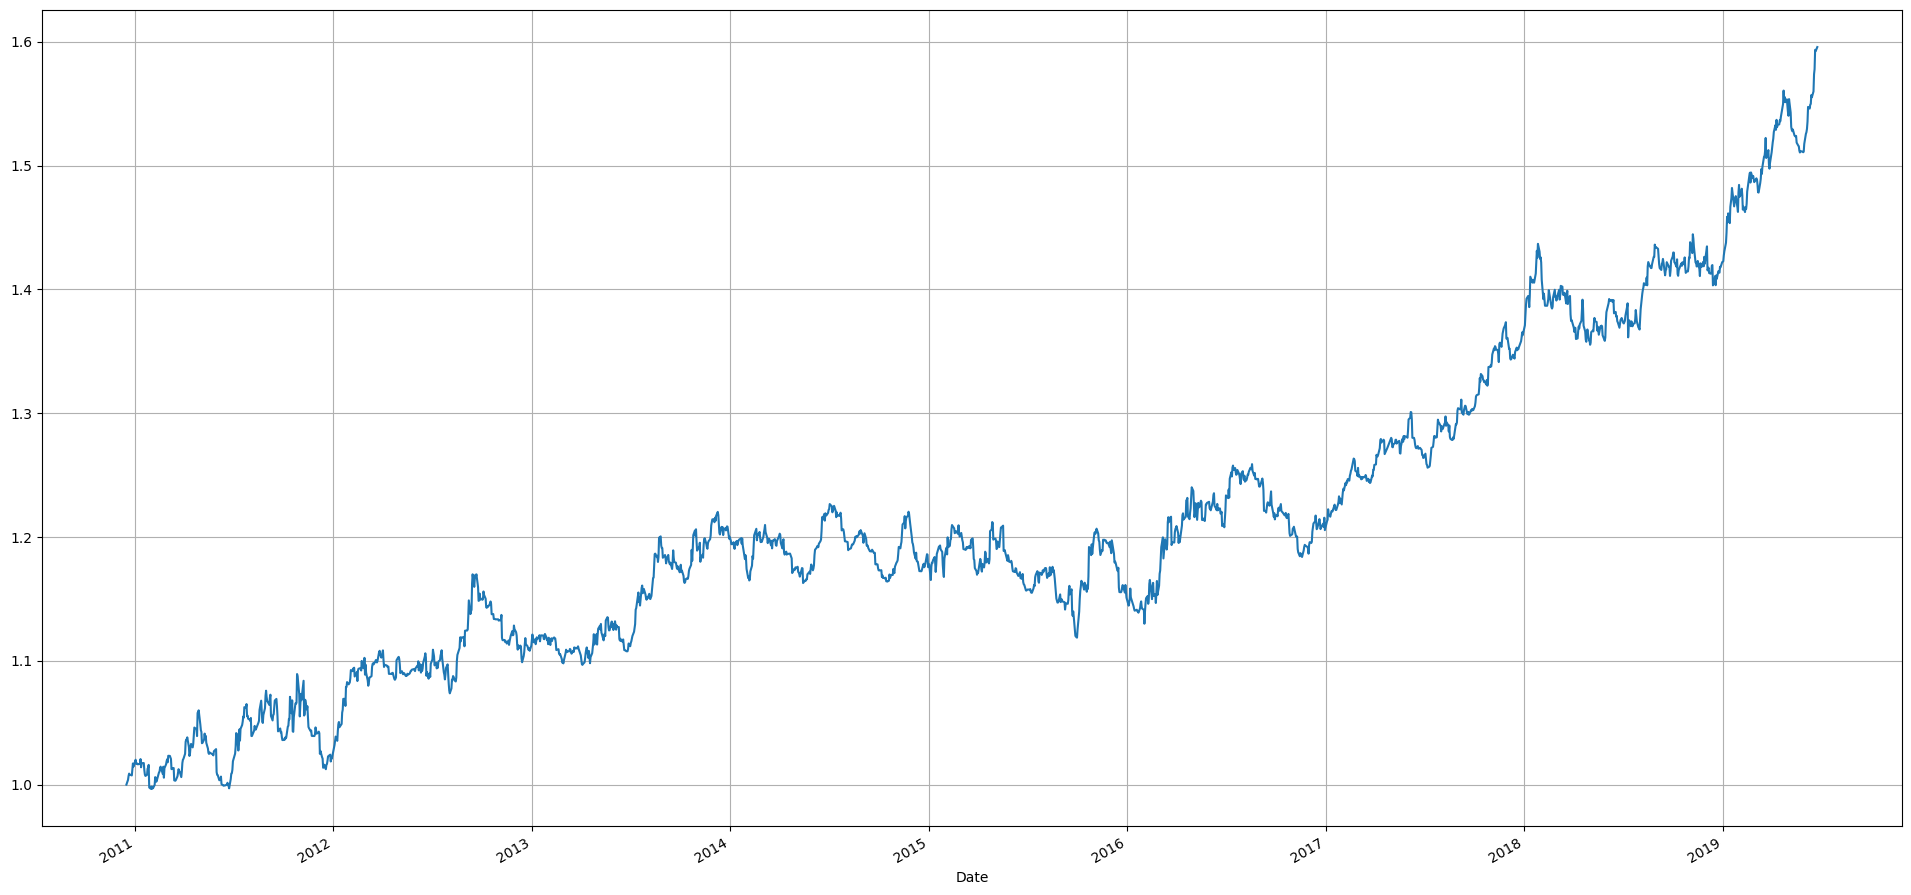

In [35]:
# 누적수익률을 plot해보겠습니다
final_rtn.plot(figsize=(24,12))
plt.grid();